In [1]:
import os
import sys
sys.path.insert(1, '/mnt/d/PowerTAC/Python/python_utils/helper') 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from statistics import mean
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
from read_mongo_collection import HelperToReadMongo
from data_processing import DataProcessor
from network_activities import Network
from customer_info import CustomerInfo

import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set_theme(style="darkgrid")

# See complete data
# pd.set_option('max_columns', None)
# pd.set_option("max_rows", None)
# np.set_printoptions(threshold=np.inf)

In [3]:
helper_mongo = HelperToReadMongo()
data_processor = DataProcessor()
network = Network()
customer_info = CustomerInfo()

In [4]:
# Configurable Parameters

look_back = 24
look_ahead = 24
num_features = 96

In [5]:
def mean_absolute_percentage_error(y_true, y_pred):
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data Processing

In [6]:
# Specify names of all the databases here
database = 'PowerTAC2021_CUP_Data_Collection'

# Specify the storage path along with directory
storage_path = '/mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models'
os.makedirs(storage_path, exist_ok=True) 

# Specify list of the collections to be analysed here
non_customers_collection = ['DistributionTransaction_and_Report_Info', 'Calendar_Info', 'WeatherReport_Info', 'WeatherForecast_Info']
list_of_customers_collections = helper_mongo.connect_to_mongo(database).list_collection_names()

for item in non_customers_collection:
    list_of_customers_collections.remove(item)

In [7]:
db = helper_mongo.query_to_mongo(database, 'BrooksideHomes', server_ip='10.2.16.159', ssh_username='powertac', \
                                         ssh_password='sanjay9397', remote=False)

db1 = helper_mongo.query_to_mongo(database, 'BrooksideHomes', server_ip='10.2.16.159', ssh_username='powertac', \
                                         ssh_password='sanjay9397', remote=True)

In [8]:
db.head()

,Game Name,Timeslot,Max_Usage,Min_Usage,Avg_Usage,Tariff,Usage Per Population
0,finals_2019_07_6_3510,362,0.965697,0.198326,0.449997,0.385371,0.478853
1,finals_2019_07_6_3510,363,0.965697,0.198326,0.449997,0.385371,0.452728
2,finals_2019_07_6_3510,364,0.965697,0.198326,0.449997,0.385371,0.362337
3,finals_2019_07_6_3510,365,0.965697,0.198326,0.449997,0.385371,0.320839
4,finals_2019_07_6_3510,366,0.965697,0.198326,0.449997,0.260774,0.306059


In [9]:
db1.head()

,Game Name,Timeslot,Max_Usage,Min_Usage,Avg_Usage,Tariff,Usage Per Population
0,finals_2019_07_6_4446,362,0.965697,0.198326,0.449997,0.363434,0.303949
1,finals_2019_07_6_4446,363,0.965697,0.198326,0.449997,0.363434,0.295545
2,finals_2019_07_6_4446,364,0.965697,0.198326,0.449997,0.363434,0.297942
3,finals_2019_07_6_4446,365,0.965697,0.198326,0.449997,0.363434,0.321814
4,finals_2019_07_6_4446,366,0.965697,0.198326,0.449997,0.035706,0.517701


In [10]:
db.shape

(21740, 7)

In [11]:
db1.shape

(26611, 7)

In [12]:
def predict_usage(customer, dataframe):
    
    try:
        
        features = ['Day_of_Month', 'Day_of_Week', 'Hour_of_Day', 'Temperature', 'Wind_Speed', 
                   'Wind_Direction', 'Cloud_Cover', 'Avg_Usage', 'Min_Usage', 'Max_Usage', 'Tariff', 'Usage Per Population']
        
        dataframe = dataframe[features]
        
        # print(dataframe)
        
        dataframe_with_lag = data_processor.shift_n_lags(dataframe, 0, 168, features)
        dataframe_with_lag['Usage_at_Lag_1'] = data_processor.shift_n_lags(dataframe, 1, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_2'] = data_processor.shift_n_lags(dataframe, 2, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_3'] = data_processor.shift_n_lags(dataframe, 3, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_4'] = data_processor.shift_n_lags(dataframe, 4, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_5'] = data_processor.shift_n_lags(dataframe, 5, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_6'] = data_processor.shift_n_lags(dataframe, 6, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_7'] = data_processor.shift_n_lags(dataframe, 7, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_8'] = data_processor.shift_n_lags(dataframe, 8, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_9'] = data_processor.shift_n_lags(dataframe, 9, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_10'] = data_processor.shift_n_lags(dataframe, 10, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_11'] = data_processor.shift_n_lags(dataframe, 11, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_12'] = data_processor.shift_n_lags(dataframe, 12, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_13'] = data_processor.shift_n_lags(dataframe, 13, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_14'] = data_processor.shift_n_lags(dataframe, 14, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_15'] = data_processor.shift_n_lags(dataframe, 15, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_16'] = data_processor.shift_n_lags(dataframe, 16, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_17'] = data_processor.shift_n_lags(dataframe, 17, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_18'] = data_processor.shift_n_lags(dataframe, 18, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_19'] = data_processor.shift_n_lags(dataframe, 19, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_20'] = data_processor.shift_n_lags(dataframe, 20, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_21'] = data_processor.shift_n_lags(dataframe, 21, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_22'] = data_processor.shift_n_lags(dataframe, 22, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_23'] = data_processor.shift_n_lags(dataframe, 23, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_24'] = data_processor.shift_n_lags(dataframe, 24, 168, 'Usage Per Population')
        dataframe_with_lag['Usage_at_Lag_168'] = data_processor.shift_n_lags(dataframe, 168, 168, 'Usage Per Population')
        
        # print(dataframe_with_lag)

        df_encoded = data_processor.onehot_encoder(dataframe_with_lag, ['Day_of_Month', 'Day_of_Week', 'Hour_of_Day'])
        
        train, test = data_processor.train_test_split(df_encoded)

        scaler = data_processor.get_scaler()
        normalized_train = data_processor.normalize_minmax(scaler, train)
        normalized_test = data_processor.normalize_minmax(scaler, test, fit = False)
        
        scaler_storage_path = storage_path + '/scalers'
        os.makedirs(scaler_storage_path, exist_ok=True) 
        store_scaler = scaler_storage_path + '/' + customer + '.save'
        joblib.dump(scaler, store_scaler)

        Usage_Per_Population_index = list(train.columns).index('Usage Per Population')

        cols = list(df_encoded.columns)
        cols.remove('Usage Per Population')
        cols.append('Usage Per Population')
        
        normalized_train = normalized_train[cols].values
        normalized_test = normalized_test[cols].values

        path = storage_path + '/' + customer
        os.makedirs(path, exist_ok=True)
                
        network = Network()
                
        train_X, train_Y = data_processor.create_lstm_dataset(normalized_train, num_features = num_features, look_back = look_back, look_ahead = look_ahead)
        test_X, test_Y = data_processor.create_lstm_dataset(normalized_test, num_features = num_features, look_back = look_back, look_ahead = look_ahead)
        model = network.create_lstm_network_2(look_back, num_features = num_features, num_labels = look_ahead)

        model = network.train_network(model, train_X, train_Y, path, validation_split = 0.15, epochs = 20, batch_size = 64, patience = 10)
        #model.load_weights(path + '/best_model.hdf5')

        predicted_value= model.predict(test_X)

        reverse_scaler = data_processor.get_scaler()
        reverse_scaler.min_, reverse_scaler.scale_ = scaler.min_[Usage_Per_Population_index], scaler.scale_[Usage_Per_Population_index]

        predicted_test_Y = np.squeeze(reverse_scaler.inverse_transform(predicted_value))

        original_test_Y = test['Usage Per Population'][look_back:-(look_ahead-1)]

        plt.plot(list(predicted_test_Y[:100,0]), marker='o', color= 'red')
        plt.plot(original_test_Y.values.tolist()[:100], marker='o', color='green')
        plt.savefig(path + '/img1.png')
        plt.close()
        
        plt.plot(list(predicted_test_Y[200:300,0]), marker='o', color= 'red')
        plt.plot(original_test_Y.values.tolist()[200:300], marker='o', color='green')
        plt.savefig(path + '/img2.png')
        plt.close()
        
        plt.plot(list(predicted_test_Y[400:500,0]), marker='o', color= 'red')
        plt.plot(original_test_Y.values.tolist()[400:500], marker='o', color='green')
        plt.savefig(path + '/img3.png')
        plt.close()
        
        plt.plot(list(predicted_test_Y[:1000,0]), marker='o', color= 'red')
        plt.plot(original_test_Y.values.tolist()[:1000], marker='o', color='green')
        plt.show()
        
        print("MAE : " + str(mean_absolute_error(list(predicted_test_Y[:,0]), original_test_Y.values.tolist())))
        print("MSE : " + str(mean_squared_error(list(predicted_test_Y[:,0]), original_test_Y.values.tolist())))

        mape = 0
            
        try:
            mape = mean_absolute_percentage_error((predicted_test_Y[:,0]), original_test_Y.values.tolist())
        except Exception as e:
            print(e)
        
        f = open(path + 'loss.csv', 'w')
        f.write(str(mean_absolute_error(list(predicted_test_Y[:,0]), original_test_Y.values.tolist())) + "," +
                str(mean_squared_error(list(predicted_test_Y[:,0]), original_test_Y.values.tolist())) + "," +
                str(mape) + "\n")
        f.close() 

    except Exception as e:
        print(e) 


Epoch 1/20
498/498 [==============================] - 35s 64ms/step - loss: 0.0122 - val_loss: 0.0101

Epoch 00001: val_loss improved from inf to 0.01008, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 NS Controllable/model-01-0.01.hdf5
Epoch 2/20
498/498 [==============================] - 28s 57ms/step - loss: 0.0101 - val_loss: 0.0100

Epoch 00002: val_loss improved from 0.01008 to 0.00998, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 NS Controllable/model-02-0.01.hdf5
Epoch 3/20
498/498 [==============================] - 27s 54ms/step - loss: 0.0096 - val_loss: 0.0102

Epoch 00003: val_loss did not improve from 0.00998
Epoch 4/20
498/498 [==============================] - 27s 54ms/step - loss: 0.0091 - val_loss: 0.0107

Epoch 00004: val_loss did not improve from 0.00998
Epoch 5/20
498/498 [==============================] - 28s 57ms/step - loss: 0.0087 - val_loss: 0.0106

Epoch 00005: val_los

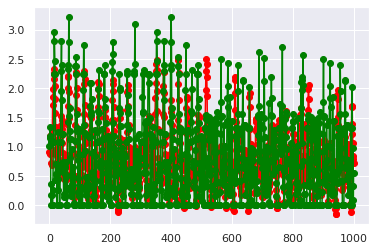

MAE : 0.3925234710520354
MSE : 0.2835404570841397

Epoch 1/20
499/499 [==============================] - 32s 58ms/step - loss: 0.0135 - val_loss: 0.0158

Epoch 00001: val_loss improved from inf to 0.01577, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/OfficeComplex 2 SS Controllable/model-01-0.02.hdf5
Epoch 2/20
499/499 [==============================] - 29s 57ms/step - loss: 0.0090 - val_loss: 0.0150

Epoch 00002: val_loss improved from 0.01577 to 0.01497, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/OfficeComplex 2 SS Controllable/model-02-0.01.hdf5
Epoch 3/20
499/499 [==============================] - 28s 56ms/step - loss: 0.0070 - val_loss: 0.0160

Epoch 00003: val_loss did not improve from 0.01497
Epoch 4/20
499/499 [==============================] - 29s 58ms/step - loss: 0.0051 - val_loss: 0.0168

Epoch 00004: val_loss did not improve from 0.01497
Epoch 5/20
499/499 [==============================] - 28s 57m

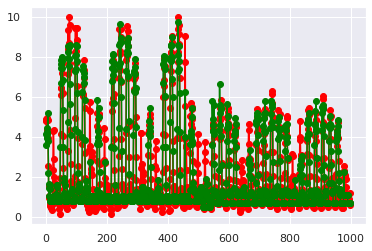

MAE : 0.5416239814572146
MSE : 0.8431069457065321
Error in Calendar_Forecast_Info

Epoch 1/20
500/500 [==============================] - 33s 59ms/step - loss: 0.0217 - val_loss: 0.0153

Epoch 00001: val_loss improved from inf to 0.01531, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/seafood-2/model-01-0.02.hdf5
Epoch 2/20
500/500 [==============================] - 29s 58ms/step - loss: 0.0139 - val_loss: 0.0149

Epoch 00002: val_loss improved from 0.01531 to 0.01485, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/seafood-2/model-02-0.01.hdf5
Epoch 3/20
500/500 [==============================] - 28s 57ms/step - loss: 0.0129 - val_loss: 0.0143

Epoch 00003: val_loss improved from 0.01485 to 0.01432, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/seafood-2/model-03-0.01.hdf5
Epoch 4/20
500/500 [==============================] - 29s 58ms/step - loss: 0.0120 - val_loss: 0.0157

Epoch 00

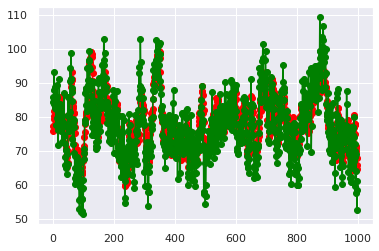

MAE : 5.287049707532084
MSE : 44.103793435413735

Epoch 1/20
499/499 [==============================] - 33s 59ms/step - loss: 0.0189 - val_loss: 0.0142

Epoch 00001: val_loss improved from inf to 0.01415, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/seafood-1/model-01-0.01.hdf5
Epoch 2/20
499/499 [==============================] - 30s 59ms/step - loss: 0.0133 - val_loss: 0.0133

Epoch 00002: val_loss improved from 0.01415 to 0.01334, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/seafood-1/model-02-0.01.hdf5
Epoch 3/20
499/499 [==============================] - 29s 57ms/step - loss: 0.0123 - val_loss: 0.0136

Epoch 00003: val_loss did not improve from 0.01334
Epoch 4/20
499/499 [==============================] - 29s 58ms/step - loss: 0.0116 - val_loss: 0.0137

Epoch 00004: val_loss did not improve from 0.01334
Epoch 5/20
499/499 [==============================] - 28s 56ms/step - loss: 0.0108 - val_loss: 0.0146

Epo

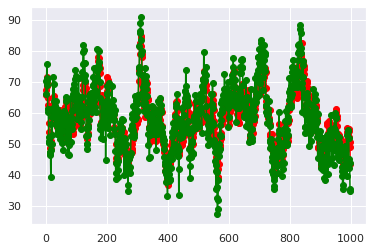

MAE : 4.602708719897146
MSE : 33.427858973577194

Epoch 1/20
498/498 [==============================] - 34s 61ms/step - loss: 0.0355 - val_loss: 0.0236

Epoch 00001: val_loss improved from inf to 0.02357, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/MedicalCenter-2/model-01-0.02.hdf5
Epoch 2/20
498/498 [==============================] - 29s 58ms/step - loss: 0.0233 - val_loss: 0.0209

Epoch 00002: val_loss improved from 0.02357 to 0.02094, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/MedicalCenter-2/model-02-0.02.hdf5
Epoch 3/20
498/498 [==============================] - 28s 57ms/step - loss: 0.0197 - val_loss: 0.0194

Epoch 00003: val_loss improved from 0.02094 to 0.01938, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/MedicalCenter-2/model-03-0.02.hdf5
Epoch 4/20
498/498 [==============================] - 29s 58ms/step - loss: 0.0177 - val_loss: 0.0182

Epoch 00004: val_loss i

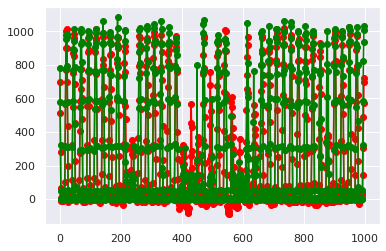

MAE : 77.38035168549624
MSE : 22566.184307157386

Epoch 1/20
510/510 [==============================] - 67s 113ms/step - loss: 0.0099 - val_loss: 0.0049

Epoch 00001: val_loss improved from inf to 0.00491, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 ReS Controllable/model-01-0.00.hdf5
Epoch 2/20
510/510 [==============================] - 44s 86ms/step - loss: 0.0077 - val_loss: 0.0048

Epoch 00002: val_loss improved from 0.00491 to 0.00478, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 ReS Controllable/model-02-0.00.hdf5
Epoch 3/20
510/510 [==============================] - 40s 79ms/step - loss: 0.0073 - val_loss: 0.0046

Epoch 00003: val_loss improved from 0.00478 to 0.00462, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 ReS Controllable/model-03-0.00.hdf5
Epoch 4/20
510/510 [==============================] - 39s 76ms/step - loss: 0.0067 - val_los

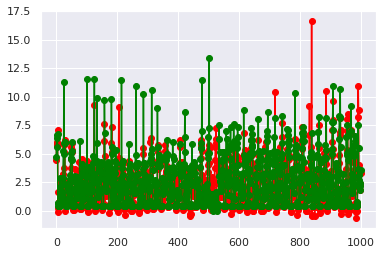

MAE : 0.8514453503461191
MSE : 2.200201016699788

Epoch 1/20
498/498 [==============================] - 42s 77ms/step - loss: 0.0099 - val_loss: 0.0050

Epoch 00001: val_loss improved from inf to 0.00502, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 RaS Controllable/model-01-0.01.hdf5
Epoch 2/20
498/498 [==============================] - 38s 77ms/step - loss: 0.0079 - val_loss: 0.0049

Epoch 00002: val_loss improved from 0.00502 to 0.00486, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 RaS Controllable/model-02-0.00.hdf5
Epoch 3/20
498/498 [==============================] - 52s 104ms/step - loss: 0.0075 - val_loss: 0.0048

Epoch 00003: val_loss improved from 0.00486 to 0.00479, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 RaS Controllable/model-03-0.00.hdf5
Epoch 4/20
498/498 [==============================] - 44s 88ms/step - loss: 0.0070 - val_los

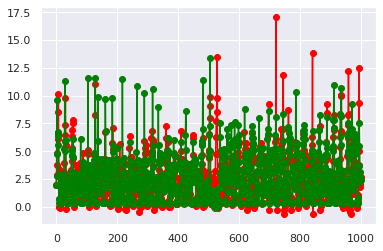

MAE : 0.8599077524478642
MSE : 2.2994958857514707

Epoch 1/20
499/499 [==============================] - 42s 76ms/step - loss: 0.0887 - val_loss: 0.0810

Epoch 00001: val_loss improved from inf to 0.08105, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/WindmillCoOp-2/model-01-0.08.hdf5
Epoch 2/20
499/499 [==============================] - 36s 73ms/step - loss: 0.0719 - val_loss: 0.0721

Epoch 00002: val_loss improved from 0.08105 to 0.07212, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/WindmillCoOp-2/model-02-0.07.hdf5
Epoch 3/20
499/499 [==============================] - 45s 89ms/step - loss: 0.0642 - val_loss: 0.0683

Epoch 00003: val_loss improved from 0.07212 to 0.06833, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/WindmillCoOp-2/model-03-0.07.hdf5
Epoch 4/20
499/499 [==============================] - 41s 81ms/step - loss: 0.0597 - val_loss: 0.0646

Epoch 00004: val_loss imp

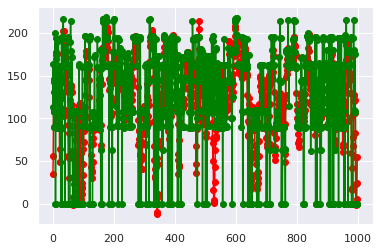

MAE : 41.39971364559142
MSE : 3091.360238156823

Epoch 1/20
510/510 [==============================] - 60s 103ms/step - loss: 0.0197 - val_loss: 0.0201

Epoch 00001: val_loss improved from inf to 0.02012, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 ReS Base/model-01-0.02.hdf5
Epoch 2/20
510/510 [==============================] - 44s 87ms/step - loss: 0.0133 - val_loss: 0.0178

Epoch 00002: val_loss improved from 0.02012 to 0.01781, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 ReS Base/model-02-0.02.hdf5
Epoch 3/20
510/510 [==============================] - 45s 89ms/step - loss: 0.0111 - val_loss: 0.0157

Epoch 00003: val_loss improved from 0.01781 to 0.01571, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 ReS Base/model-03-0.02.hdf5
Epoch 4/20
510/510 [==============================] - 57s 111ms/step - loss: 0.0097 - val_loss: 0.0153

Epoch 00004: 

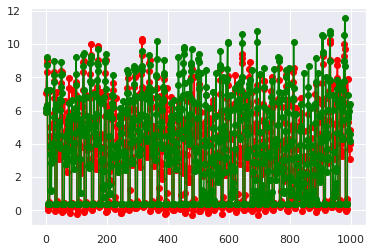

MAE : 0.7370616239853973
MSE : 1.1156822597068488

Epoch 1/20
512/512 [==============================] - 47s 84ms/step - loss: 0.0055 - val_loss: 0.0051

Epoch 00001: val_loss improved from inf to 0.00514, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 RaS Controllable/model-01-0.01.hdf5
Epoch 2/20
512/512 [==============================] - 44s 86ms/step - loss: 0.0042 - val_loss: 0.0050

Epoch 00002: val_loss improved from 0.00514 to 0.00497, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 RaS Controllable/model-02-0.00.hdf5
Epoch 3/20
512/512 [==============================] - 38s 74ms/step - loss: 0.0040 - val_loss: 0.0047

Epoch 00003: val_loss improved from 0.00497 to 0.00465, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 RaS Controllable/model-03-0.00.hdf5
Epoch 4/20
512/512 [==============================] - 35s 68ms/step - loss: 0.0037 - val_los

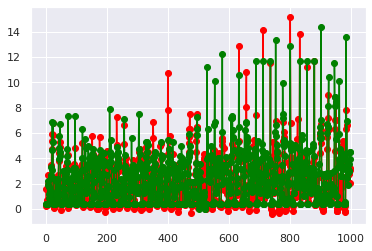

MAE : 0.9364575624251349
MSE : 2.480621343498164

Epoch 1/20
517/517 [==============================] - 43s 76ms/step - loss: 0.0176 - val_loss: 0.0174

Epoch 00001: val_loss improved from inf to 0.01743, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/OfficeComplex 1 SS Controllable/model-01-0.02.hdf5
Epoch 2/20
517/517 [==============================] - 40s 78ms/step - loss: 0.0108 - val_loss: 0.0133

Epoch 00002: val_loss improved from 0.01743 to 0.01331, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/OfficeComplex 1 SS Controllable/model-02-0.01.hdf5
Epoch 3/20
517/517 [==============================] - 37s 72ms/step - loss: 0.0069 - val_loss: 0.0118

Epoch 00003: val_loss improved from 0.01331 to 0.01177, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/OfficeComplex 1 SS Controllable/model-03-0.01.hdf5
Epoch 4/20
517/517 [==============================] - 33s 65ms/step - loss: 0.

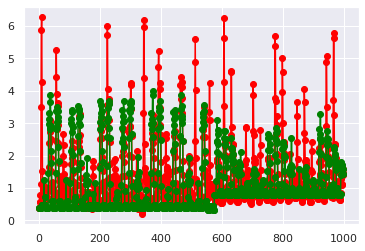

MAE : 0.42903960743519753
MSE : 0.6139602896365282

Epoch 1/20
501/501 [==============================] - 39s 70ms/step - loss: 0.0098 - val_loss: 0.0051

Epoch 00001: val_loss improved from inf to 0.00508, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 SS Controllable/model-01-0.01.hdf5
Epoch 2/20
501/501 [==============================] - 29s 57ms/step - loss: 0.0079 - val_loss: 0.0049

Epoch 00002: val_loss improved from 0.00508 to 0.00495, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 SS Controllable/model-02-0.00.hdf5
Epoch 3/20
501/501 [==============================] - 29s 59ms/step - loss: 0.0074 - val_loss: 0.0048

Epoch 00003: val_loss improved from 0.00495 to 0.00477, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 SS Controllable/model-03-0.00.hdf5
Epoch 4/20
501/501 [==============================] - 29s 57ms/step - loss: 0.0069 - val_loss:

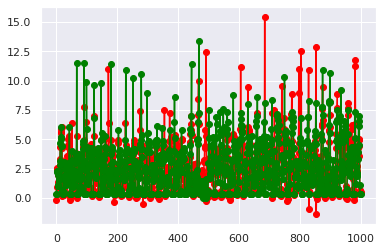

MAE : 0.8508212127774579
MSE : 2.174936463016055

Epoch 1/20
512/512 [==============================] - 35s 60ms/step - loss: 0.0054 - val_loss: 0.0051

Epoch 00001: val_loss improved from inf to 0.00514, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 SS Controllable/model-01-0.01.hdf5
Epoch 2/20
512/512 [==============================] - 30s 58ms/step - loss: 0.0042 - val_loss: 0.0049

Epoch 00002: val_loss improved from 0.00514 to 0.00490, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 SS Controllable/model-02-0.00.hdf5
Epoch 3/20
512/512 [==============================] - 29s 57ms/step - loss: 0.0039 - val_loss: 0.0046

Epoch 00003: val_loss improved from 0.00490 to 0.00456, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 SS Controllable/model-03-0.00.hdf5
Epoch 4/20
512/512 [==============================] - 29s 56ms/step - loss: 0.0037 - val_loss: 0

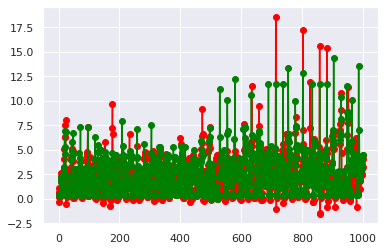

MAE : 0.975276944191876
MSE : 2.6773272914608763

Epoch 1/20
514/514 [==============================] - 55s 94ms/step - loss: 0.0300 - val_loss: 0.0148

Epoch 00001: val_loss improved from inf to 0.01483, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/fc3/model-01-0.01.hdf5
Epoch 2/20
514/514 [==============================] - 36s 69ms/step - loss: 0.0129 - val_loss: 0.0106

Epoch 00002: val_loss improved from 0.01483 to 0.01056, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/fc3/model-02-0.01.hdf5
Epoch 3/20
514/514 [==============================] - 36s 70ms/step - loss: 0.0101 - val_loss: 0.0090

Epoch 00003: val_loss improved from 0.01056 to 0.00905, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/fc3/model-03-0.01.hdf5
Epoch 4/20
514/514 [==============================] - 60s 117ms/step - loss: 0.0084 - val_loss: 0.0075

Epoch 00004: val_loss improved from 0.00905 to 0.00754, sa

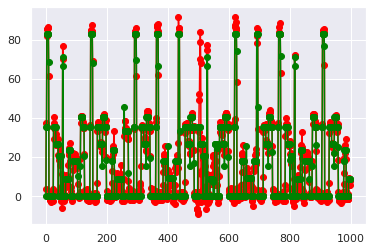

MAE : 2.4546867363205878
MSE : 18.08455731704824

Epoch 1/20
517/517 [==============================] - 41s 71ms/step - loss: 0.0196 - val_loss: 0.0199

Epoch 00001: val_loss improved from inf to 0.01986, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 RaS Base/model-01-0.02.hdf5
Epoch 2/20
517/517 [==============================] - 33s 64ms/step - loss: 0.0129 - val_loss: 0.0188

Epoch 00002: val_loss improved from 0.01986 to 0.01879, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 RaS Base/model-02-0.02.hdf5
Epoch 3/20
517/517 [==============================] - 34s 66ms/step - loss: 0.0110 - val_loss: 0.0252

Epoch 00003: val_loss did not improve from 0.01879
Epoch 4/20
517/517 [==============================] - 33s 64ms/step - loss: 0.0101 - val_loss: 0.0156

Epoch 00004: val_loss improved from 0.01879 to 0.01558, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/V

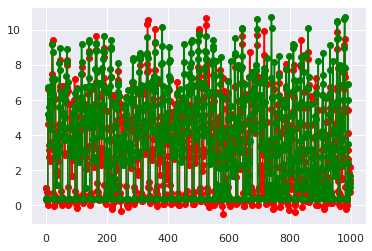

MAE : 0.7672864457391434
MSE : 1.1917773507802591

Epoch 1/20
510/510 [==============================] - 62s 93ms/step - loss: 0.0413 - val_loss: 0.0119

Epoch 00001: val_loss improved from inf to 0.01190, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/HextraChemical/model-01-0.01.hdf5
Epoch 2/20
510/510 [==============================] - 36s 70ms/step - loss: 0.0120 - val_loss: 0.0106

Epoch 00002: val_loss improved from 0.01190 to 0.01063, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/HextraChemical/model-02-0.01.hdf5
Epoch 3/20
510/510 [==============================] - 30s 59ms/step - loss: 0.0100 - val_loss: 0.0075

Epoch 00003: val_loss improved from 0.01063 to 0.00746, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/HextraChemical/model-03-0.01.hdf5
Epoch 4/20
510/510 [==============================] - 31s 61ms/step - loss: 0.0088 - val_loss: 0.0069

Epoch 00004: val_loss imp

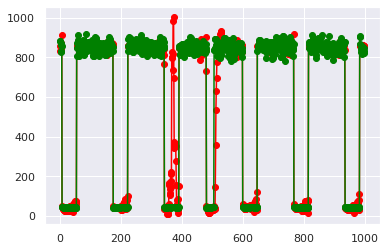

MAE : 27.84852760097911
MSE : 5891.4680281960445

Epoch 1/20
501/501 [==============================] - 33s 59ms/step - loss: 0.0153 - val_loss: 0.0061

Epoch 00001: val_loss improved from inf to 0.00612, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 NS Controllable/model-01-0.01.hdf5
Epoch 2/20
501/501 [==============================] - 29s 57ms/step - loss: 0.0118 - val_loss: 0.0058

Epoch 00002: val_loss improved from 0.00612 to 0.00583, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 NS Controllable/model-02-0.01.hdf5
Epoch 3/20
501/501 [==============================] - 29s 59ms/step - loss: 0.0109 - val_loss: 0.0059

Epoch 00003: val_loss did not improve from 0.00583
Epoch 4/20
501/501 [==============================] - 29s 58ms/step - loss: 0.0102 - val_loss: 0.0061

Epoch 00004: val_loss did not improve from 0.00583
Epoch 5/20
501/501 [==============================] - 29s 58ms/step - loss

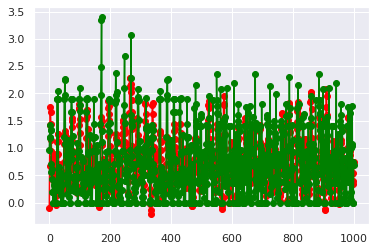

MAE : 0.4636413624831382
MSE : 0.3884851481117786

Epoch 1/20
510/510 [==============================] - 55s 99ms/step - loss: 0.0303 - val_loss: 0.0213

Epoch 00001: val_loss improved from inf to 0.02129, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/SunnyhillSolar1/model-01-0.02.hdf5
Epoch 2/20
510/510 [==============================] - 39s 76ms/step - loss: 0.0191 - val_loss: 0.0181

Epoch 00002: val_loss improved from 0.02129 to 0.01806, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/SunnyhillSolar1/model-02-0.02.hdf5
Epoch 3/20
510/510 [==============================] - 31s 62ms/step - loss: 0.0158 - val_loss: 0.0163

Epoch 00003: val_loss improved from 0.01806 to 0.01634, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/SunnyhillSolar1/model-03-0.02.hdf5
Epoch 4/20
510/510 [==============================] - 32s 63ms/step - loss: 0.0142 - val_loss: 0.0158

Epoch 00004: val_loss 

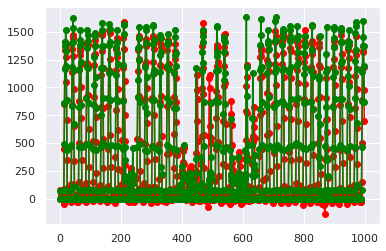

MAE : 96.6140894629657
MSE : 37820.57741445361

Epoch 1/20
501/501 [==============================] - 33s 60ms/step - loss: 0.0166 - val_loss: 0.0181

Epoch 00001: val_loss improved from inf to 0.01810, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 NS Base/model-01-0.02.hdf5
Epoch 2/20
501/501 [==============================] - 29s 57ms/step - loss: 0.0114 - val_loss: 0.0167

Epoch 00002: val_loss improved from 0.01810 to 0.01675, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 NS Base/model-02-0.02.hdf5
Epoch 3/20
501/501 [==============================] - 29s 58ms/step - loss: 0.0097 - val_loss: 0.0150

Epoch 00003: val_loss improved from 0.01675 to 0.01496, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 NS Base/model-03-0.01.hdf5
Epoch 4/20
501/501 [==============================] - 29s 58ms/step - loss: 0.0083 - val_loss: 0.0145

Epoch 00004: val_lo

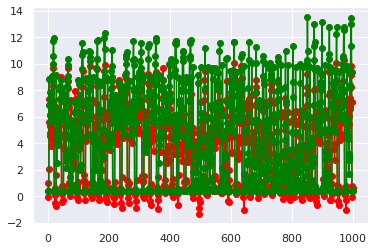

MAE : 1.0612444814231365
MSE : 2.2913738754605557

Epoch 1/20
499/499 [==============================] - 34s 61ms/step - loss: 0.0129 - val_loss: 0.0177

Epoch 00001: val_loss improved from inf to 0.01770, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/OfficeComplex 2 NS Base/model-01-0.02.hdf5
Epoch 2/20
499/499 [==============================] - 29s 58ms/step - loss: 0.0089 - val_loss: 0.0162

Epoch 00002: val_loss improved from 0.01770 to 0.01623, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/OfficeComplex 2 NS Base/model-02-0.02.hdf5
Epoch 3/20
499/499 [==============================] - 30s 60ms/step - loss: 0.0070 - val_loss: 0.0170

Epoch 00003: val_loss did not improve from 0.01623
Epoch 4/20
499/499 [==============================] - 30s 60ms/step - loss: 0.0056 - val_loss: 0.0183

Epoch 00004: val_loss did not improve from 0.01623
Epoch 5/20
499/499 [==============================] - 29s 59ms/step - loss: 0

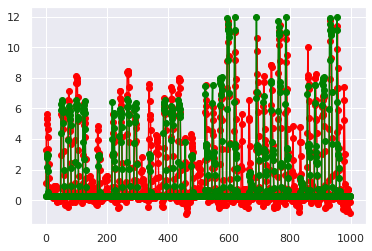

MAE : 1.1120827733708718
MSE : 3.8324802074421345

Epoch 1/20
499/499 [==============================] - 34s 60ms/step - loss: 0.1030 - val_loss: 0.0949

Epoch 00001: val_loss improved from inf to 0.09489, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/WindmillCoOp-1/model-01-0.09.hdf5
Epoch 2/20
499/499 [==============================] - 30s 59ms/step - loss: 0.0871 - val_loss: 0.0906

Epoch 00002: val_loss improved from 0.09489 to 0.09058, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/WindmillCoOp-1/model-02-0.09.hdf5
Epoch 3/20
499/499 [==============================] - 29s 59ms/step - loss: 0.0821 - val_loss: 0.0843

Epoch 00003: val_loss improved from 0.09058 to 0.08433, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/WindmillCoOp-1/model-03-0.08.hdf5
Epoch 4/20
499/499 [==============================] - 30s 60ms/step - loss: 0.0774 - val_loss: 0.0827

Epoch 00004: val_loss imp

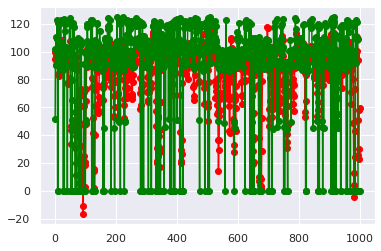

MAE : 24.232045376121825
MSE : 1210.792559454458

Epoch 1/20
501/501 [==============================] - 34s 62ms/step - loss: 0.0145 - val_loss: 0.0104

Epoch 00001: val_loss improved from inf to 0.01041, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/OfficeComplex 1 NS Base/model-01-0.01.hdf5
Epoch 2/20
501/501 [==============================] - 30s 60ms/step - loss: 0.0100 - val_loss: 0.0107

Epoch 00002: val_loss did not improve from 0.01041
Epoch 3/20
501/501 [==============================] - 30s 61ms/step - loss: 0.0075 - val_loss: 0.0124

Epoch 00003: val_loss did not improve from 0.01041
Epoch 4/20
501/501 [==============================] - 30s 60ms/step - loss: 0.0060 - val_loss: 0.0128

Epoch 00004: val_loss did not improve from 0.01041
Epoch 5/20
501/501 [==============================] - 30s 60ms/step - loss: 0.0050 - val_loss: 0.0138

Epoch 00005: val_loss did not improve from 0.01041
Epoch 6/20
501/501 [==============================] - 

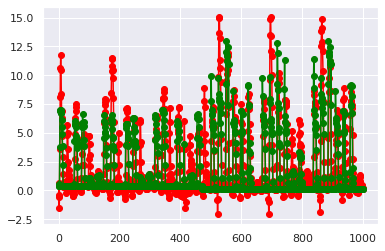

MAE : 1.182174806663392
MSE : 4.751420153252352

Epoch 1/20
513/513 [==============================] - 35s 61ms/step - loss: 0.0121 - val_loss: 0.0163

Epoch 00001: val_loss improved from inf to 0.01630, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/OfficeComplex 2 SS Base/model-01-0.02.hdf5
Epoch 2/20
513/513 [==============================] - 30s 59ms/step - loss: 0.0080 - val_loss: 0.0175

Epoch 00002: val_loss did not improve from 0.01630
Epoch 3/20
513/513 [==============================] - 32s 62ms/step - loss: 0.0062 - val_loss: 0.0169

Epoch 00003: val_loss did not improve from 0.01630
Epoch 4/20
513/513 [==============================] - 30s 59ms/step - loss: 0.0051 - val_loss: 0.0170

Epoch 00004: val_loss did not improve from 0.01630
Epoch 5/20
513/513 [==============================] - 30s 59ms/step - loss: 0.0043 - val_loss: 0.0184

Epoch 00005: val_loss did not improve from 0.01630
Epoch 6/20
513/513 [==============================] - 3

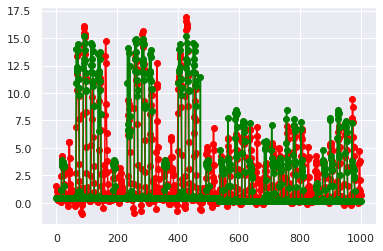

MAE : 0.9621077405514477
MSE : 3.361176410994016

Epoch 1/20
516/516 [==============================] - 36s 63ms/step - loss: 0.0203 - val_loss: 0.0200

Epoch 00001: val_loss improved from inf to 0.01996, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 SS Base/model-01-0.02.hdf5
Epoch 2/20
516/516 [==============================] - 31s 60ms/step - loss: 0.0130 - val_loss: 0.0179

Epoch 00002: val_loss improved from 0.01996 to 0.01786, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 SS Base/model-02-0.02.hdf5
Epoch 3/20
516/516 [==============================] - 31s 60ms/step - loss: 0.0110 - val_loss: 0.0159

Epoch 00003: val_loss improved from 0.01786 to 0.01589, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 SS Base/model-03-0.02.hdf5
Epoch 4/20
516/516 [==============================] - 31s 60ms/step - loss: 0.0094 - val_loss: 0.0152

Epoch 00004: val_

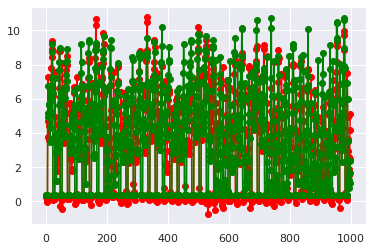

MAE : 0.726323775336159
MSE : 1.0777817496007809

Epoch 1/20
514/514 [==============================] - 36s 62ms/step - loss: 0.0074 - val_loss: 0.0062

Epoch 00001: val_loss improved from inf to 0.00622, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/OfficeComplex 1 NS Controllable/model-01-0.01.hdf5
Epoch 2/20
514/514 [==============================] - 30s 59ms/step - loss: 0.0059 - val_loss: 0.0062

Epoch 00002: val_loss improved from 0.00622 to 0.00619, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/OfficeComplex 1 NS Controllable/model-02-0.01.hdf5
Epoch 3/20
514/514 [==============================] - 31s 61ms/step - loss: 0.0052 - val_loss: 0.0059

Epoch 00003: val_loss improved from 0.00619 to 0.00587, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/OfficeComplex 1 NS Controllable/model-03-0.01.hdf5
Epoch 4/20
514/514 [==============================] - 31s 60ms/step - loss: 0.

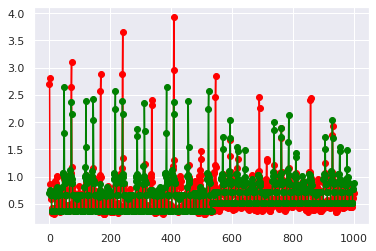

MAE : 0.12057125550523487
MSE : 0.06476294026185188

Epoch 1/20
502/502 [==============================] - 35s 62ms/step - loss: 0.0166 - val_loss: 0.0122

Epoch 00001: val_loss improved from inf to 0.01218, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/OfficeComplex 1 SS Base/model-01-0.01.hdf5
Epoch 2/20
502/502 [==============================] - 30s 61ms/step - loss: 0.0108 - val_loss: 0.0169

Epoch 00002: val_loss did not improve from 0.01218
Epoch 3/20
502/502 [==============================] - 30s 60ms/step - loss: 0.0077 - val_loss: 0.0158

Epoch 00003: val_loss did not improve from 0.01218
Epoch 4/20
502/502 [==============================] - 30s 60ms/step - loss: 0.0063 - val_loss: 0.0160

Epoch 00004: val_loss did not improve from 0.01218
Epoch 5/20
502/502 [==============================] - 30s 60ms/step - loss: 0.0054 - val_loss: 0.0216

Epoch 00005: val_loss did not improve from 0.01218
Epoch 6/20
502/502 [==============================]

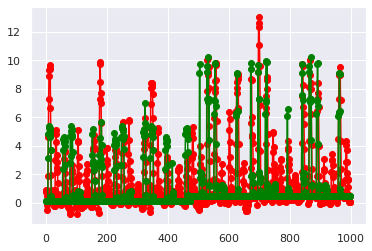

MAE : 1.1457742231943853
MSE : 3.8729182674353275

Epoch 1/20
499/499 [==============================] - 34s 61ms/step - loss: 0.0153 - val_loss: 0.0047

Epoch 00001: val_loss improved from inf to 0.00473, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/DowntownOffices/model-01-0.00.hdf5
Epoch 2/20
499/499 [==============================] - 29s 59ms/step - loss: 0.0059 - val_loss: 0.0036

Epoch 00002: val_loss improved from 0.00473 to 0.00358, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/DowntownOffices/model-02-0.00.hdf5
Epoch 3/20
499/499 [==============================] - 29s 59ms/step - loss: 0.0049 - val_loss: 0.0035

Epoch 00003: val_loss improved from 0.00358 to 0.00346, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/DowntownOffices/model-03-0.00.hdf5
Epoch 4/20
499/499 [==============================] - 30s 61ms/step - loss: 0.0046 - val_loss: 0.0036

Epoch 00004: val_loss 

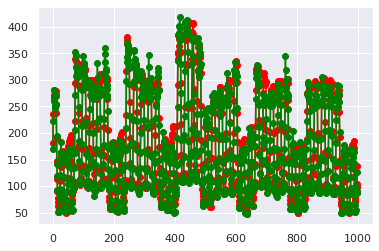

MAE : 14.645453237332747
MSE : 472.66506494586463

Epoch 1/20
515/515 [==============================] - 35s 62ms/step - loss: 0.0026 - val_loss: 9.5442e-04

Epoch 00001: val_loss improved from inf to 0.00095, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/FrostyStorage/model-01-0.00.hdf5
Epoch 2/20
515/515 [==============================] - 31s 60ms/step - loss: 0.0011 - val_loss: 8.1013e-04

Epoch 00002: val_loss improved from 0.00095 to 0.00081, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/FrostyStorage/model-02-0.00.hdf5
Epoch 3/20
515/515 [==============================] - 31s 60ms/step - loss: 9.8783e-04 - val_loss: 7.0734e-04

Epoch 00003: val_loss improved from 0.00081 to 0.00071, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/FrostyStorage/model-03-0.00.hdf5
Epoch 4/20
515/515 [==============================] - 31s 60ms/step - loss: 8.4860e-04 - val_loss: 6.0476e-04

Epoc

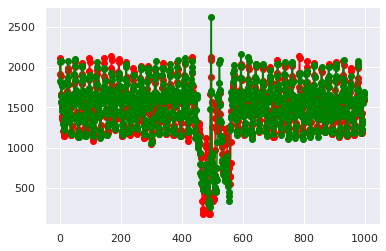

MAE : 95.96083780113702
MSE : 20308.237926223024

Epoch 1/20
512/512 [==============================] - 35s 62ms/step - loss: 0.0058 - val_loss: 0.0061

Epoch 00001: val_loss improved from inf to 0.00607, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/OfficeComplex 2 NS Controllable/model-01-0.01.hdf5
Epoch 2/20
512/512 [==============================] - 31s 61ms/step - loss: 0.0045 - val_loss: 0.0062

Epoch 00002: val_loss did not improve from 0.00607
Epoch 3/20
512/512 [==============================] - 32s 62ms/step - loss: 0.0038 - val_loss: 0.0061

Epoch 00003: val_loss did not improve from 0.00607
Epoch 4/20
512/512 [==============================] - 31s 60ms/step - loss: 0.0030 - val_loss: 0.0059

Epoch 00004: val_loss improved from 0.00607 to 0.00592, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/OfficeComplex 2 NS Controllable/model-04-0.01.hdf5
Epoch 5/20
512/512 [==============================] - 31s 60ms

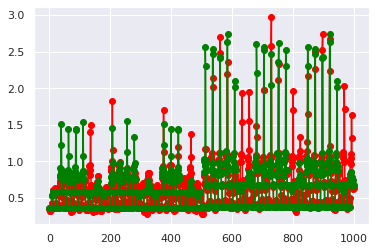

MAE : 0.12810942724802446
MSE : 0.0771186555691699

Epoch 1/20
516/516 [==============================] - 36s 62ms/step - loss: 0.0221 - val_loss: 0.0216

Epoch 00001: val_loss improved from inf to 0.02161, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/fc2/model-01-0.02.hdf5
Epoch 2/20
516/516 [==============================] - 31s 60ms/step - loss: 0.0181 - val_loss: 0.0188

Epoch 00002: val_loss improved from 0.02161 to 0.01884, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/fc2/model-02-0.02.hdf5
Epoch 3/20
516/516 [==============================] - 31s 60ms/step - loss: 0.0164 - val_loss: 0.0179

Epoch 00003: val_loss improved from 0.01884 to 0.01789, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/fc2/model-03-0.02.hdf5
Epoch 4/20
516/516 [==============================] - 31s 60ms/step - loss: 0.0152 - val_loss: 0.0172

Epoch 00004: val_loss improved from 0.01789 to 0.01717, s

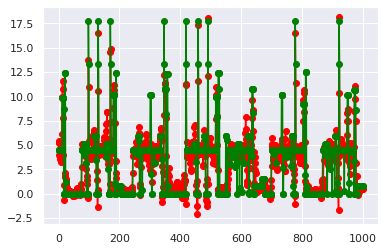

MAE : 1.071979137577275
MSE : 3.6970917403486876

Epoch 1/20
510/510 [==============================] - 35s 61ms/step - loss: 0.0151 - val_loss: 0.0095

Epoch 00001: val_loss improved from inf to 0.00951, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 RaS Base/model-01-0.01.hdf5
Epoch 2/20
510/510 [==============================] - 30s 59ms/step - loss: 0.0091 - val_loss: 0.0088

Epoch 00002: val_loss improved from 0.00951 to 0.00878, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 RaS Base/model-02-0.01.hdf5
Epoch 3/20
510/510 [==============================] - 30s 59ms/step - loss: 0.0078 - val_loss: 0.0077

Epoch 00003: val_loss improved from 0.00878 to 0.00766, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 RaS Base/model-03-0.01.hdf5
Epoch 4/20
510/510 [==============================] - 31s 60ms/step - loss: 0.0065 - val_loss: 0.0070

Epoch 00004: v

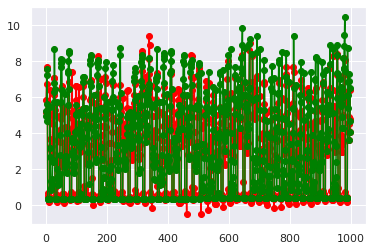

MAE : 0.8031879134383215
MSE : 1.3841512666254092

Epoch 1/20
498/498 [==============================] - 34s 62ms/step - loss: 0.0122 - val_loss: 0.0068

Epoch 00001: val_loss improved from inf to 0.00677, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/MedicalCenter-1/model-01-0.01.hdf5
Epoch 2/20
498/498 [==============================] - 30s 60ms/step - loss: 0.0061 - val_loss: 0.0059

Epoch 00002: val_loss improved from 0.00677 to 0.00591, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/MedicalCenter-1/model-02-0.01.hdf5
Epoch 3/20
498/498 [==============================] - 30s 60ms/step - loss: 0.0054 - val_loss: 0.0057

Epoch 00003: val_loss improved from 0.00591 to 0.00565, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/MedicalCenter-1/model-03-0.01.hdf5
Epoch 4/20
498/498 [==============================] - 30s 60ms/step - loss: 0.0049 - val_loss: 0.0051

Epoch 00004: val_loss 

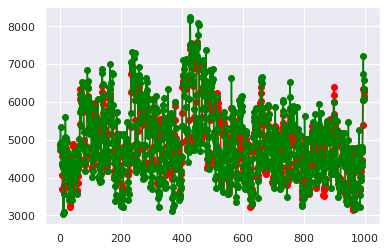

MAE : 347.7052856583925
MSE : 213098.61779370217

Epoch 1/20
512/512 [==============================] - 35s 62ms/step - loss: 0.0158 - val_loss: 0.0064

Epoch 00001: val_loss improved from inf to 0.00644, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 NS Base/model-01-0.01.hdf5
Epoch 2/20
512/512 [==============================] - 31s 60ms/step - loss: 0.0103 - val_loss: 0.0056

Epoch 00002: val_loss improved from 0.00644 to 0.00560, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 NS Base/model-02-0.01.hdf5
Epoch 3/20
512/512 [==============================] - 31s 60ms/step - loss: 0.0084 - val_loss: 0.0049

Epoch 00003: val_loss improved from 0.00560 to 0.00491, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 2 NS Base/model-03-0.00.hdf5
Epoch 4/20
512/512 [==============================] - 31s 60ms/step - loss: 0.0072 - val_loss: 0.0052

Epoch 00004: val_

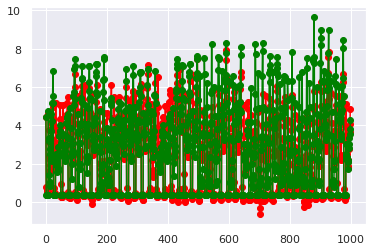

MAE : 0.6809978855557363
MSE : 0.9676363236839373

Epoch 1/20
512/512 [==============================] - 35s 62ms/step - loss: 0.0087 - val_loss: 0.0083

Epoch 00001: val_loss improved from inf to 0.00833, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/BrooksideHomes/model-01-0.01.hdf5
Epoch 2/20
512/512 [==============================] - 30s 59ms/step - loss: 0.0078 - val_loss: 0.0079

Epoch 00002: val_loss improved from 0.00833 to 0.00785, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/BrooksideHomes/model-02-0.01.hdf5
Epoch 3/20
512/512 [==============================] - 30s 59ms/step - loss: 0.0074 - val_loss: 0.0077

Epoch 00003: val_loss improved from 0.00785 to 0.00774, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/BrooksideHomes/model-03-0.01.hdf5
Epoch 4/20
512/512 [==============================] - 31s 60ms/step - loss: 0.0072 - val_loss: 0.0078

Epoch 00004: val_loss did

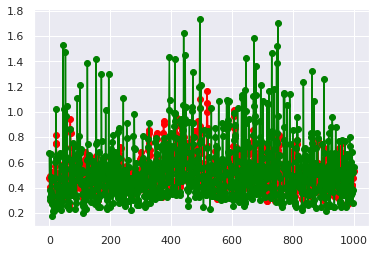

MAE : 0.15825824413755651
MSE : 0.04730613743424898

Epoch 1/20
501/501 [==============================] - 36s 64ms/step - loss: 0.0179 - val_loss: 0.0137

Epoch 00001: val_loss improved from inf to 0.01370, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/SolarLeasing/model-01-0.01.hdf5
Epoch 2/20
501/501 [==============================] - 30s 61ms/step - loss: 0.0133 - val_loss: 0.0121

Epoch 00002: val_loss improved from 0.01370 to 0.01214, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/SolarLeasing/model-02-0.01.hdf5
Epoch 3/20
501/501 [==============================] - 30s 61ms/step - loss: 0.0115 - val_loss: 0.0117

Epoch 00003: val_loss improved from 0.01214 to 0.01169, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/SolarLeasing/model-03-0.01.hdf5
Epoch 4/20
501/501 [==============================] - 31s 61ms/step - loss: 0.0106 - val_loss: 0.0113

Epoch 00004: val_loss improve

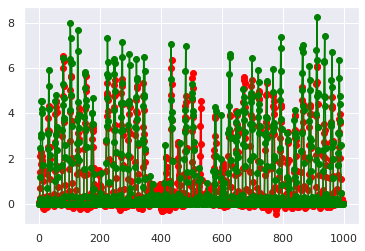

MAE : 0.5556507673535956
MSE : 1.0101668862140638

Epoch 1/20
508/508 [==============================] - 35s 61ms/step - loss: 0.0208 - val_loss: 0.0163

Epoch 00001: val_loss improved from inf to 0.01625, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/freezeco-1/model-01-0.02.hdf5
Epoch 2/20
508/508 [==============================] - 31s 60ms/step - loss: 0.0144 - val_loss: 0.0156

Epoch 00002: val_loss improved from 0.01625 to 0.01555, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/freezeco-1/model-02-0.02.hdf5
Epoch 3/20
508/508 [==============================] - 30s 60ms/step - loss: 0.0134 - val_loss: 0.0164

Epoch 00003: val_loss did not improve from 0.01555
Epoch 4/20
508/508 [==============================] - 30s 60ms/step - loss: 0.0125 - val_loss: 0.0163

Epoch 00004: val_loss did not improve from 0.01555
Epoch 5/20
508/508 [==============================] - 31s 61ms/step - loss: 0.0118 - val_loss: 0.0178



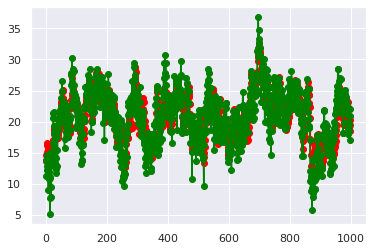

MAE : 2.3799086578077358
MSE : 8.973121790515409

Epoch 1/20
501/501 [==============================] - 34s 62ms/step - loss: 0.0186 - val_loss: 0.0133

Epoch 00001: val_loss improved from inf to 0.01330, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/freezeco-2/model-01-0.01.hdf5
Epoch 2/20
501/501 [==============================] - 30s 60ms/step - loss: 0.0129 - val_loss: 0.0124

Epoch 00002: val_loss improved from 0.01330 to 0.01240, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/freezeco-2/model-02-0.01.hdf5
Epoch 3/20
501/501 [==============================] - 30s 60ms/step - loss: 0.0120 - val_loss: 0.0122

Epoch 00003: val_loss improved from 0.01240 to 0.01223, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/freezeco-2/model-03-0.01.hdf5
Epoch 4/20
501/501 [==============================] - 30s 61ms/step - loss: 0.0113 - val_loss: 0.0125

Epoch 00004: val_loss did not improve 

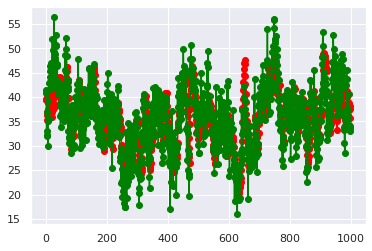

MAE : 3.730129083212705
MSE : 21.807515295785016

Epoch 1/20
501/501 [==============================] - 34s 61ms/step - loss: 0.0058 - val_loss: 0.0048

Epoch 00001: val_loss improved from inf to 0.00479, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 ReS Controllable/model-01-0.00.hdf5
Epoch 2/20
501/501 [==============================] - 29s 59ms/step - loss: 0.0044 - val_loss: 0.0046

Epoch 00002: val_loss improved from 0.00479 to 0.00462, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 ReS Controllable/model-02-0.00.hdf5
Epoch 3/20
501/501 [==============================] - 30s 59ms/step - loss: 0.0041 - val_loss: 0.0043

Epoch 00003: val_loss improved from 0.00462 to 0.00429, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 ReS Controllable/model-03-0.00.hdf5
Epoch 4/20
501/501 [==============================] - 31s 61ms/step - loss: 0.0038 - val_loss

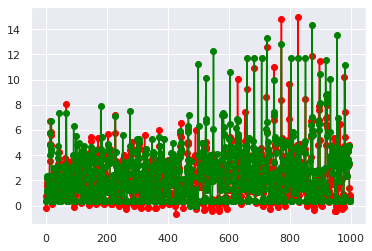

MAE : 0.9348839594548265
MSE : 2.579264538899206

Epoch 1/20
510/510 [==============================] - 35s 61ms/step - loss: 0.0314 - val_loss: 0.0222

Epoch 00001: val_loss improved from inf to 0.02220, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/SunnyhillSolar2/model-01-0.02.hdf5
Epoch 2/20
510/510 [==============================] - 31s 61ms/step - loss: 0.0199 - val_loss: 0.0195

Epoch 00002: val_loss improved from 0.02220 to 0.01949, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/SunnyhillSolar2/model-02-0.02.hdf5
Epoch 3/20
510/510 [==============================] - 31s 60ms/step - loss: 0.0169 - val_loss: 0.0184

Epoch 00003: val_loss improved from 0.01949 to 0.01841, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/SunnyhillSolar2/model-03-0.02.hdf5
Epoch 4/20
510/510 [==============================] - 31s 60ms/step - loss: 0.0152 - val_loss: 0.0173

Epoch 00004: val_loss i

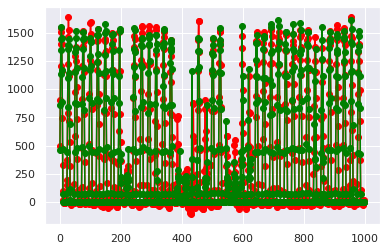

MAE : 97.55351174878083
MSE : 38374.90073802195

Epoch 1/20
501/501 [==============================] - 36s 65ms/step - loss: 0.0152 - val_loss: 0.0097

Epoch 00001: val_loss improved from inf to 0.00966, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 ReS Base/model-01-0.01.hdf5
Epoch 2/20
501/501 [==============================] - 30s 60ms/step - loss: 0.0095 - val_loss: 0.0089

Epoch 00002: val_loss improved from 0.00966 to 0.00887, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 ReS Base/model-02-0.01.hdf5
Epoch 3/20
501/501 [==============================] - 30s 61ms/step - loss: 0.0083 - val_loss: 0.0081

Epoch 00003: val_loss improved from 0.00887 to 0.00806, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 ReS Base/model-03-0.01.hdf5
Epoch 4/20
501/501 [==============================] - 30s 61ms/step - loss: 0.0071 - val_loss: 0.0074

Epoch 00004: va

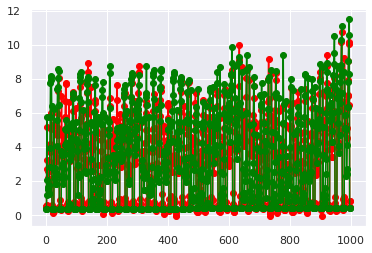

MAE : 0.8360045419269295
MSE : 1.457156913190245

Epoch 1/20
502/502 [==============================] - 34s 61ms/step - loss: 0.0202 - val_loss: 0.0090

Epoch 00001: val_loss improved from inf to 0.00905, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/freezeco-3/model-01-0.01.hdf5
Epoch 2/20
502/502 [==============================] - 31s 62ms/step - loss: 0.0074 - val_loss: 0.0092

Epoch 00002: val_loss did not improve from 0.00905
Epoch 3/20
502/502 [==============================] - 31s 61ms/step - loss: 0.0064 - val_loss: 0.0086

Epoch 00003: val_loss improved from 0.00905 to 0.00858, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/freezeco-3/model-03-0.01.hdf5
Epoch 4/20
502/502 [==============================] - 31s 62ms/step - loss: 0.0058 - val_loss: 0.0108

Epoch 00004: val_loss did not improve from 0.00858
Epoch 5/20
502/502 [==============================] - 31s 62ms/step - loss: 0.0055 - val_loss: 0.0087

E

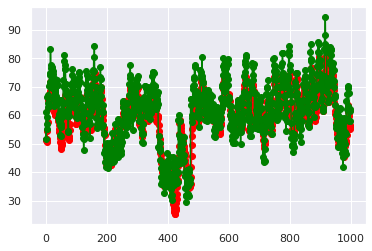

MAE : 4.529501925630749
MSE : 32.78966120738085

Epoch 1/20
501/501 [==============================] - 36s 64ms/step - loss: 0.0153 - val_loss: 0.0130

Epoch 00001: val_loss improved from inf to 0.01302, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/CentervilleHomes/model-01-0.01.hdf5
Epoch 2/20
501/501 [==============================] - 31s 61ms/step - loss: 0.0124 - val_loss: 0.0119

Epoch 00002: val_loss improved from 0.01302 to 0.01192, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/CentervilleHomes/model-02-0.01.hdf5
Epoch 3/20
501/501 [==============================] - 31s 61ms/step - loss: 0.0115 - val_loss: 0.0119

Epoch 00003: val_loss improved from 0.01192 to 0.01186, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/CentervilleHomes/model-03-0.01.hdf5
Epoch 4/20
501/501 [==============================] - 31s 62ms/step - loss: 0.0111 - val_loss: 0.0118

Epoch 00004: val_loss

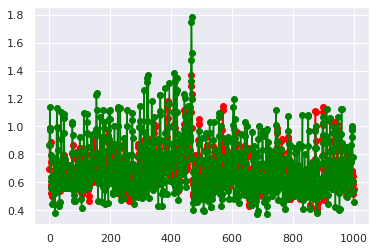

MAE : 0.12611520323193567
MSE : 0.029176407717481548

Epoch 1/20
502/502 [==============================] - 36s 65ms/step - loss: 0.0537 - val_loss: 0.0459

Epoch 00001: val_loss improved from inf to 0.04593, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/EastsideOffices/model-01-0.05.hdf5
Epoch 2/20
502/502 [==============================] - 32s 63ms/step - loss: 0.0441 - val_loss: 0.0469

Epoch 00002: val_loss did not improve from 0.04593
Epoch 3/20
502/502 [==============================] - 31s 61ms/step - loss: 0.0412 - val_loss: 0.0450

Epoch 00003: val_loss improved from 0.04593 to 0.04502, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/EastsideOffices/model-03-0.05.hdf5
Epoch 4/20
502/502 [==============================] - 31s 61ms/step - loss: 0.0383 - val_loss: 0.0461

Epoch 00004: val_loss did not improve from 0.04502
Epoch 5/20
502/502 [==============================] - 31s 61ms/step - loss: 0.0360 - val_l

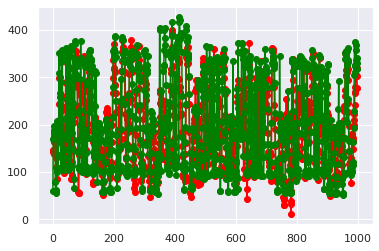

MAE : 53.76045053393209
MSE : 4941.859395713637

Epoch 1/20
512/512 [==============================] - 37s 64ms/step - loss: 0.0213 - val_loss: 0.0157

Epoch 00001: val_loss improved from inf to 0.01567, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/sf2/model-01-0.02.hdf5
Epoch 2/20
512/512 [==============================] - 32s 62ms/step - loss: 0.0137 - val_loss: 0.0130

Epoch 00002: val_loss improved from 0.01567 to 0.01303, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/sf2/model-02-0.01.hdf5
Epoch 3/20
512/512 [==============================] - 31s 62ms/step - loss: 0.0108 - val_loss: 0.0107

Epoch 00003: val_loss improved from 0.01303 to 0.01066, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/sf2/model-03-0.01.hdf5
Epoch 4/20
512/512 [==============================] - 32s 62ms/step - loss: 0.0086 - val_loss: 0.0092

Epoch 00004: val_loss improved from 0.01066 to 0.00920, savi

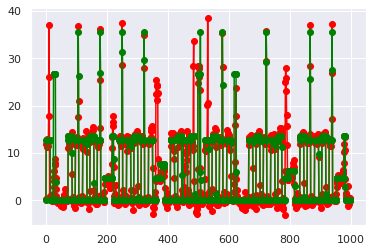

MAE : 1.1507023686143965
MSE : 8.275117102321211

Epoch 1/20
512/512 [==============================] - 36s 63ms/step - loss: 0.0383 - val_loss: 0.0253

Epoch 00001: val_loss improved from inf to 0.02534, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/sf3/model-01-0.03.hdf5
Epoch 2/20
512/512 [==============================] - 31s 61ms/step - loss: 0.0190 - val_loss: 0.0155

Epoch 00002: val_loss improved from 0.02534 to 0.01546, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/sf3/model-02-0.02.hdf5
Epoch 3/20
512/512 [==============================] - 32s 62ms/step - loss: 0.0130 - val_loss: 0.0128

Epoch 00003: val_loss improved from 0.01546 to 0.01283, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/sf3/model-03-0.01.hdf5
Epoch 4/20
512/512 [==============================] - 31s 61ms/step - loss: 0.0111 - val_loss: 0.0114

Epoch 00004: val_loss improved from 0.01283 to 0.01138, sav

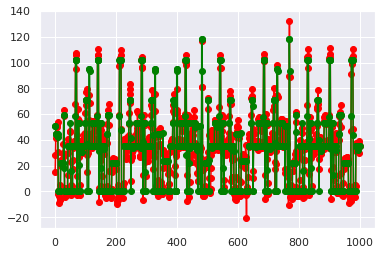

MAE : 5.859615937428275
MSE : 94.54320075333557

Epoch 1/20
499/499 [==============================] - 36s 63ms/step - loss: 0.0149 - val_loss: 0.0095

Epoch 00001: val_loss improved from inf to 0.00954, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 SS Base/model-01-0.01.hdf5
Epoch 2/20
499/499 [==============================] - 30s 61ms/step - loss: 0.0098 - val_loss: 0.0092

Epoch 00002: val_loss improved from 0.00954 to 0.00919, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 SS Base/model-02-0.01.hdf5
Epoch 3/20
499/499 [==============================] - 31s 63ms/step - loss: 0.0086 - val_loss: 0.0081

Epoch 00003: val_loss improved from 0.00919 to 0.00808, saving model to /mnt/d/PowerTAC/PowerTAC2021/brokers/VidyutVanika21/python/models/Village 1 SS Base/model-03-0.01.hdf5
Epoch 4/20
499/499 [==============================] - 30s 61ms/step - loss: 0.0074 - val_loss: 0.0076

Epoch 00004: val_l

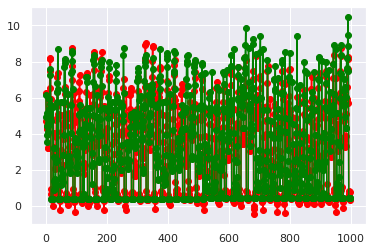

MAE : 0.8314223616528298
MSE : 1.5158323642623748


In [13]:
for collection in list_of_customers_collections:
        
        try:
            
            db_cust = helper_mongo.query_to_mongo(database, collection, server_ip='10.2.16.159', ssh_username='powertac', \
                                         ssh_password='sanjay9397', remote=False)
        
            db_calendar = helper_mongo.query_to_mongo(database, 'Calendar_Info', server_ip='10.2.16.159', ssh_username='powertac', \
                                             ssh_password='sanjay9397', remote=False)

            db_weather = helper_mongo.query_to_mongo(database, 'WeatherReport_Info', server_ip='10.2.16.159', ssh_username='powertac', \
                                                     ssh_password='sanjay9397', remote=False)

            temp_db = pd.merge(db_calendar, db_weather,  how='inner', left_on=['Game_Name', 'Timeslot'], right_on = ['Game_Name', 'Timeslot'])
            db = pd.merge(temp_db, db_cust, how='inner', left_on=['Game_Name', 'Timeslot'], right_on = ['Game Name', 'Timeslot'])

            db_cust1 = helper_mongo.query_to_mongo(database, collection, server_ip='10.2.16.159', ssh_username='powertac', \
                                             ssh_password='sanjay9397', remote=True)

            db_calendar1 = helper_mongo.query_to_mongo(database, 'Calendar_Info', server_ip='10.2.16.159', ssh_username='powertac', \
                                             ssh_password='sanjay9397', remote=True)

            db_weather1 = helper_mongo.query_to_mongo(database, 'WeatherReport_Info', server_ip='10.2.16.159', ssh_username='powertac', \
                                                     ssh_password='sanjay9397', remote=True)

            temp_db1 = pd.merge(db_calendar1, db_weather1,  how='inner', left_on=['Game_Name', 'Timeslot'], right_on = ['Game_Name', 'Timeslot'])
            db1 = pd.merge(temp_db1, db_cust1, how='inner', left_on=['Game_Name', 'Timeslot'], right_on = ['Game Name', 'Timeslot'])

            frames = [db, db1]
            final_db = pd.concat(frames)
            final_db.shape
            predict_usage(collection, final_db)
            
        except:
            print("Error in " + collection)